In [131]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [157]:
import numpy as np
import multiset as ms
from sys import maxsize

import pandas as pd
from sklearn.datasets import load_iris

In [18]:
p =ms.Multiset([1,3,4,4,3,5,6]).difference([3])

# Exchangeability Model

## Conformal Algorithm using old predictions alone

This are the observations we want to assess:

In [53]:
list_fisher = [17,20,10,17,12,15,19,22,17,
               19,14,22,18,17,13,12,18,15,17]

We first define the non-conformity measure associated with fisher problem.

In [52]:
def non_conformity_fisher(bag, example):
    n = len(bag)
    z_bar_bag = np.mean(bag)
    print(z_bar_bag*n)
    return(abs(((n*z_bar_bag+example)/(n+1))-example))

Then we can define the algorithm as stated in the paper :

In [38]:
def conformal_algorithm_from_old_examples(non_conformity_measure,previous_examples_list, example, error=.05):
    n = len(previous_examples_list)+1
    examples_list = previous_examples_list+[example]
    alpha = np.zeros(n)
    for i in range(n):
        bag = ms.Multiset(examples_list).difference([examples_list[i]])
        alpha[i] = non_conformity_measure(bag, examples_list[i])
    p_z = sum(alpha > alpha[n-1])/n
    return p_z >= error
        

Predicting for a number of reasonable values for z:

In [40]:
[conformal_algorithm_from_old_examples(non_conformity_fisher, list_fisher, i) for i in range(30)]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False]

# 1.2 Conformal Algorithm using new object

Let's implement the nonconformity measure for nearest neighbours, as in the paper if the denominator is 0 and the numerator is not then the result should be infinity (or in this case the maximum integer computable) and if they are both equal to zero then we return 0.

In [127]:
def non_conformity_nn(bag, example, label):
    distance_to_z_nn_in_bag_same_label = min([abs(x-example) for (x,y) in bag if y == label])
    distance_to_z_nn_in_bag_diff_label = min([abs(x-example) for (x,y) in bag if y != label])
    if (distance_to_z_nn_in_bag_diff_label == 0)&(distance_to_z_nn_in_bag_same_label == 0):
        return 0. 
    if (distance_to_z_nn_in_bag_diff_label == 0):
        return maxsize-1
    return distance_to_z_nn_in_bag_same_label/distance_to_z_nn_in_bag_diff_label

Implementing the supervised version of the conformal algorithm.

In [183]:
def conformal_algorithm_using_new_object(non_conformity_measure,previous_examples_list, example, label, error=.05):
    n = len(previous_examples_list)+1
    examples_list = previous_examples_list+[(example, label)]
    alpha = np.zeros(n)
    for i in range(n):
        bag = ms.Multiset(examples_list).difference([examples_list[i]])
        alpha[i] = non_conformity_measure(bag, examples_list[i][0], examples_list[i][1])
    p_y = sum(alpha > alpha[n-1])/n
    return {"test_result":p_y >= error,
            "alpha":alpha,
            "1-p_y":1-p_y
           }

Loading Iris Dataset

In [207]:
X = pd.DataFrame(load_iris()["data"], columns=load_iris()["feature_names"])
y = pd.DataFrame(load_iris()["target"], columns=["species"])
X = X[y.species.isin([0,1])]
y = y[y.species.isin([0,1])]

df = pd.concat([X,y],axis=1).sample(n=25, random_state=320)

list_obs = [(example, label) for [example, label] in df[["sepal length (cm)", "species"]].values]

We plot the Iris dataset with respect to sepal length

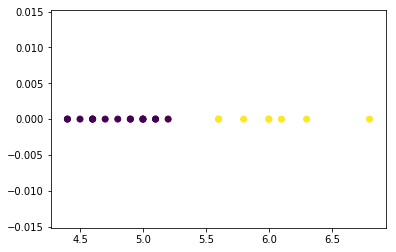

In [208]:
plt.scatter(df["sepal length (cm)"], np.zeros(25),c=df.species)

Conformal predictions for y = 0 and y = 1:

In [209]:
conformal_algorithm_using_new_object(non_conformity_nn, list_obs[:-1], list_obs[-1][0], 0.)

{'1-p_y': 0.84,
 'alpha': array([1.81818182e-01, 3.12500000e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.42857143e-01, 9.22337204e+18, 1.11111111e-01,
        0.00000000e+00, 9.22337204e+18, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.33333333e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.00000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.50000000e-01]),
 'test_result': True}

In [210]:
conformal_algorithm_using_new_object(non_conformity_nn, list_obs[:-1], list_obs[-1][0], 1.)

{'1-p_y': 0.92,
 'alpha': array([1.81818182e-01, 3.12500000e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.33333333e-01, 9.22337204e+18, 1.11111111e-01,
        0.00000000e+00, 9.22337204e+18, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.33333333e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.00000000e+00]),
 'test_result': True}

Comparing with ground truth :

In [190]:
list_obs[-1]

(4.8, 0.0)

- $\Gamma^{0,92}=\{0\}$ With confidence 92% we predict that $y_25=0$ like in the paper.
- $\Gamma^{0,95}=\{0,1\}$ No information when the confidence is too high like in the paper.
- $\Gamma^{0,33}=\emptyset$ False prediction exactly like in the paper.